In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## Climate change indicators

**E. Cimadevilla** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook computes Global Surface Air Temperature (GSAT) changes relative to the 1995–2014 and 1850–1900 averages, according to CMIP6 climate models.

In [3]:
df = pd.read_csv("../../inventory.csv")
subset = df.query('type == "opendap" & variable == "t" & project == "CMIP6" & frequency == "mon"')
subset

,location,type,variable,project,experiment,frequency
41,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,t,CMIP6,ssp245,mon
67,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,t,CMIP6,historical,mon
87,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,t,CMIP6,ssp585,mon
111,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,t,CMIP6,ssp370,mon
117,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,t,CMIP6,ssp126,mon


In [4]:
hist = xarray.open_dataset(subset[subset["experiment"] == "historical"]["location"].iloc[0]).chunk(member=1, time=100)
ssp126 = xarray.open_dataset(subset[subset["experiment"] == "ssp126"]["location"].iloc[0]).chunk(member=1, time=100)
ssp245 = xarray.open_dataset(subset[subset["experiment"] == "ssp245"]["location"].iloc[0]).chunk(member=1, time=100)
ssp370 = xarray.open_dataset(subset[subset["experiment"] == "ssp370"]["location"].iloc[0]).chunk(member=1, time=100)
ssp585 = xarray.open_dataset(subset[subset["experiment"] == "ssp585"]["location"].iloc[0]).chunk(member=1, time=100)

In [5]:
%%time

weights = np.cos(np.deg2rad(hist["lat"]))
mean_hist_1995_2014 = hist["t"].sel(time=slice("19950101", "20141231")).weighted(weights).mean(["time", "lat", "lon"]).compute(num_workers=4)
mean_hist_1850_1900 = hist["t"].sel(time=slice("18500101", "19001231")).weighted(weights).mean(["time", "lat", "lon"]).compute(num_workers=4)

mean_hist = hist["t"].sel(time=slice("19500101", None)).weighted(weights).mean(["member", "lat", "lon"]).compute(num_workers=4)
mean_ssp126 = ssp126["t"].weighted(weights).mean(["member", "lat", "lon"]).compute(num_workers=4)
mean_ssp245 = ssp245["t"].weighted(weights).mean(["member", "lat", "lon"]).compute(num_workers=4)
mean_ssp370 = ssp370["t"].weighted(weights).mean(["member", "lat", "lon"]).compute(num_workers=4)
mean_ssp585 = ssp585["t"].weighted(weights).mean(["member", "lat", "lon"]).compute(num_workers=4)

mean_spatial_hist = hist["t"].sel(time=slice("19500101", None)).weighted(weights).mean(["lat", "lon"]).compute(num_workers=4)
mean_spatial_ssp126 = ssp126["t"].weighted(weights).mean(["lat", "lon"]).compute(num_workers=4)
mean_spatial_ssp245 = ssp245["t"].weighted(weights).mean(["lat", "lon"]).compute(num_workers=4)
mean_spatial_ssp370 = ssp370["t"].weighted(weights).mean(["lat", "lon"]).compute(num_workers=4)
mean_spatial_ssp585 = ssp585["t"].weighted(weights).mean(["lat", "lon"]).compute(num_workers=4)

mean_hist_1995_2014_YE = (mean_hist - mean_hist_1995_2014).resample(time="YE").mean()
mean_ssp126_1995_2014_YE = (mean_ssp126 - mean_hist_1995_2014).resample(time="YE").mean()
mean_ssp245_1995_2014_YE = (mean_ssp245 - mean_hist_1995_2014).resample(time="YE").mean()
mean_ssp370_1995_2014_YE = (mean_ssp370 - mean_hist_1995_2014).resample(time="YE").mean()
mean_ssp585_1995_2014_YE = (mean_ssp585 - mean_hist_1995_2014).resample(time="YE").mean()

mean_hist_1850_1900_YE = (mean_hist - mean_hist_1850_1900).resample(time="YE").mean()
mean_ssp126_1850_1900_YE = (mean_ssp126 - mean_hist_1850_1900).resample(time="YE").mean()
mean_ssp245_1850_1900_YE = (mean_ssp245 - mean_hist_1850_1900).resample(time="YE").mean()
mean_ssp370_1850_1900_YE = (mean_ssp370 - mean_hist_1850_1900).resample(time="YE").mean()
mean_ssp585_1850_1900_YE = (mean_ssp585 - mean_hist_1850_1900).resample(time="YE").mean()

q_hist_1995_2014_YE = (mean_spatial_hist - mean_hist_1995_2014).resample(time="YE").mean().quantile([.05, .95], dim=["member"])
q_ssp126_1995_2014_YE = (mean_spatial_ssp126 - mean_hist_1995_2014).resample(time="YE").mean().quantile([.05, .95], dim=["member"])
q_ssp245_1995_2014_YE = (mean_spatial_ssp245 - mean_hist_1995_2014).resample(time="YE").mean().quantile([.05, .95], dim=["member"])
q_ssp370_1995_2014_YE = (mean_spatial_ssp370 - mean_hist_1995_2014).resample(time="YE").mean().quantile([.05, .95], dim=["member"])
q_ssp585_1995_2014_YE = (mean_spatial_ssp585 - mean_hist_1995_2014).resample(time="YE").mean().quantile([.05, .95], dim=["member"])

CPU times: user 5min 35s, sys: 9min 45s, total: 15min 21s
Wall time: 35min 13s


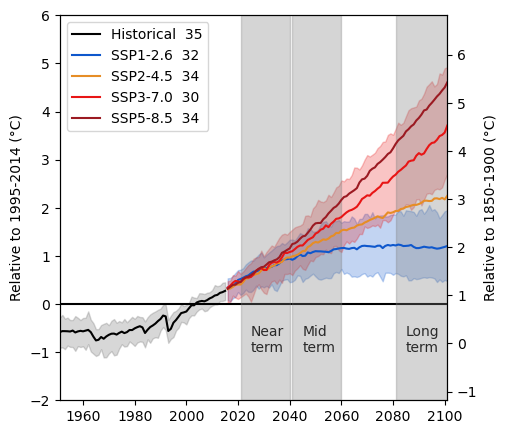

In [7]:
fig, ax = plt.subplots(figsize=(5,5))

ytop = 6

ax.fill_between(q_hist_1995_2014_YE.time,
                q_hist_1995_2014_YE.sel(quantile=.05),
                q_hist_1995_2014_YE.sel(quantile=.95),
                color="#616161", alpha=0.25)
ax.fill_between(q_ssp126_1995_2014_YE.time,
                q_ssp126_1995_2014_YE.sel(quantile=.05),
                q_ssp126_1995_2014_YE.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)
ax.fill_between(q_ssp370_1995_2014_YE.time,
                q_ssp370_1995_2014_YE.sel(quantile=.05),
                q_ssp370_1995_2014_YE.sel(quantile=.95),
                color="#e81515", alpha=0.25)
ax.set_ylim([-2, ytop])
ax.set_ylabel("Relative to 1995-2014 (°C)")
ax.axhline(y=0, color="black")
ax.text(np.datetime64('2024-12-31T00:00:00.000000000'), -1, "Near\nterm")
ax.text(np.datetime64('2044-12-31T00:00:00.000000000'), -1, "Mid\nterm")
ax.text(np.datetime64('2084-12-31T00:00:00.000000000'), -1, "Long\nterm")

ax2 = ax.twinx()
ax2.plot(mean_hist_1850_1900_YE.time, mean_hist_1850_1900_YE.mean("member"), color="#010101", label=f"Historical  {len(hist['member'])}")
ax2.plot(mean_ssp126_1850_1900_YE.time, mean_ssp126_1850_1900_YE.mean("member"), color="#0e57cc", label=f"SSP1-2.6  {len(ssp126['member'])}")
ax2.plot(mean_ssp245_1850_1900_YE.time, mean_ssp245_1850_1900_YE.mean("member"), color="#e68d26", label=f"SSP2-4.5  {len(ssp245['member'])}")
ax2.plot(mean_ssp370_1850_1900_YE.time, mean_ssp370_1850_1900_YE.mean("member"), color="#e81515", label=f"SSP3-7.0  {len(ssp370['member'])}")
ax2.plot(mean_ssp585_1850_1900_YE.time, mean_ssp585_1850_1900_YE.mean("member"), color="#9b1a22", label=f"SSP5-8.5  {len(ssp585['member'])}")
ax2.set_ylabel("Relative to 1850-1900 (°C)")
ax2.set_ylim(bottom=-2+.82, top=ytop+.82)

ax2.fill_between(
    mean_ssp126_1995_2014_YE["time"].sel(time=slice("20200101", "20400101")),
    -2+.82, ytop+.82, alpha=.33, color="grey")
ax2.fill_between(
    mean_ssp126_1995_2014_YE["time"].sel(time=slice("20400101", "20600101")),
    -2+.82, ytop+.82, alpha=.33, color="grey")
ax2.fill_between(
    mean_ssp126_1995_2014_YE["time"].sel(time=slice("20800101", None)),
    -2+.82, ytop+.82, alpha=.33, color="grey")

ax.margins(0)
ax2.margins(0)
ax2.legend()

plt.savefig("t_CMIP6_scenarios.svg")